In [8]:
pip install DeepXDE

In [9]:
import numpy as np
import deepxde as dde
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from IPython.display import display
import tensorflow as tf
dde.config.set_default_float('float64')

Set the default float type to float64


In [10]:
x_l = -25
x_r = 25
t_lower = 0
t_upper = 0.1

x = np.linspace(x_l, x_r, 256)
t = np.linspace(t_lower, t_upper, 201)
X, T = np.meshgrid(x, t)

X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))

space_domain = dde.geometry.Interval(x_l, x_r)
time_domain = dde.geometry.TimeDomain(t_lower, t_upper)
geomtime = dde.geometry.GeometryXTime(space_domain, time_domain)


k = 1
χ = 1
a = 0.5
x_0 = 15
θ_0 = np.pi / 3

a1 = 1
a2 = 1
a4 = 0.3
a6 = 0.1

b1 = 1

A1 = np.sqrt((2 * χ / b1) * (a2 - 6 * a4 * k ** 2 + 12 * a4 * k + 10 * a4 + 75 * a6 * k ** 4 + 150 * a6 * k ** 2 + 91 * a6))
C0 = a1 + 2 * a2 * k + 8 * a4 * k ** 3 + 96 * a6 * k ** 5
ω = a1 * k + a2 * k ** 2 - a2 + 3 * a4 * k ** 4 - 6 * a4 * k ** 2 - a4 + 35 * a6 * k ** 6 - 75 * a6 * k ** 4 - 15 * a6 * k ** 2 - a6

a3 = -4 * a4 * k - 40 * a6 * k ** 3
a5 = -6 * a6 * k

b2 = - (24 * a4 * χ ** 2 + 360 * a6 * χ ** 2 * k ** 2 + 840 * a6 * χ ** 2) / A1 ** 4
b3 = 720 * a6 * χ ** 3 / A1 ** 6


def pde(x, y):
    u = y[:, 0:1]
    v = y[:, 1:2]

    u_t = dde.grad.jacobian(y, x, i=0, j=1)
    v_t = dde.grad.jacobian(y, x, i=1, j=1)

    u_x = dde.grad.jacobian(y, x, i=0, j=0)
    v_x = dde.grad.jacobian(y, x, i=1, j=0)

    u_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    v_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)

    u_xxx = dde.grad.jacobian(u_xx, x, j=0)
    v_xxx = dde.grad.jacobian(v_xx, x, j=0)

    u_xxxx = dde.grad.jacobian(u_xxx, x, j=0)
    v_xxxx = dde.grad.jacobian(v_xxx, x, j=0)

    u_xxxxx = dde.grad.jacobian(u_xxxx, x, j=0)
    v_xxxxx = dde.grad.jacobian(v_xxxx, x, j=0)

    u_xxxxxx = dde.grad.jacobian(u_xxxxx, x, j=0)
    v_xxxxxx = dde.grad.jacobian(v_xxxxx, x, j=0)

    f_u = -v_t - a1 * v_x + a2 * u_xx - a3 * v_xxx + a4 * u_xxxx - a5 * v_xxxxx + a6 * u_xxxxxx + u * (b1 * (u ** 2 + v ** 2) + b2 * (u ** 2 + v ** 2) ** 2 + b3 * (u ** 2 + v ** 2) ** 3)
    f_v = u_t + a1 * u_x + a2 * v_xx + a3 * u_xxx + a4 * v_xxxx + a5 * u_xxxxx + a6 * v_xxxxxx + v * (b1 * (u ** 2 + v ** 2) + b2 * (u ** 2 + v ** 2) ** 2 + b3 * (u ** 2 + v ** 2) ** 3)

    return [f_u, f_v]


bc_u_0 = dde.icbc.DirichletBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=0
)
bc_v_0 = dde.icbc.DirichletBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=1
)


bc_u_1 = dde.icbc.NeumannBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=0
)
bc_v_1 = dde.icbc.NeumannBC(
    geomtime, lambda _: 0, lambda _, on_boundary: on_boundary, component=1
)


bc_u_2 = dde.icbc.OperatorBC(
    geomtime, lambda x, u, _: dde.grad.hessian(u, x, i=0, j=0),
    lambda _, on_boundary: on_boundary
)
bc_v_2 = dde.icbc.OperatorBC(
    geomtime, lambda x, v, _: dde.grad.hessian(v, x, i=0, j=0),
    lambda _, on_boundary: on_boundary
)


def init_cond_u(x):
    exp = np.exp(np.float128(x[:, 0:1] - x_0))

    return np.cos(k * x[:, 0:1] + θ_0) * (A1 / (a * exp + χ / (4 * a * exp)))


def init_cond_v(x):
    exp = np.exp(np.float128(x[:, 0:1] - x_0))

    return np.sin(k * x[:, 0:1] + θ_0) * (A1 / (a * exp + χ / (4 * a * exp)))


ic_u = dde.icbc.IC(geomtime, init_cond_u, lambda _, on_initial: on_initial, component=0)
ic_v = dde.icbc.IC(geomtime, init_cond_v, lambda _, on_initial: on_initial, component=1)


data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc_u_0, bc_u_1, bc_u_2, bc_v_0, bc_v_1, bc_v_2, ic_u, ic_v],
    num_domain=30000,
    num_boundary=1000,
    num_initial=3000,
    train_distribution="pseudo",
)

net = dde.nn.FNN([2] + [200] + [2], "sin", "Glorot normal")

model = dde.Model(data, net)

model.compile("adam", lr=1.1e-02, loss="MSE", loss_weights=[1, 1, 1000, 1000, 1, 1000, 1000, 1, 10000, 10000])
model.train(iterations=30000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.026089 s

'compile' took 1.627709 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
0         [1.96e+01, 5.40e-01, 3.70e+03, 1.13e+00, 1.67e-05, 4.53e+01, 2.50e+01, 1.67e-05, 4.49e+04, 1.32e+04]    [1.96e+01, 5.40e-01, 3.70e+03, 1.13e+00, 1.67e-05, 4.53e+01, 2.50e+01, 1.67e-05, 4.49e+04, 1.32e+04]    []  
1000      [6.07e+01, 3.22e+01, 2.46e+01, 6.46e+01, 2.45e+00, 4.88e+00, 3.41e+01, 2.45e+00, 4.23e+03, 4.19e+03]    [6.07e+01, 3.22e+01, 2.46e+01, 6.46e+01, 2.45e+00, 4.88e+00, 3.41e+01, 2.45e+00, 4.23e+03, 4.19e+03]    []  
2000      [5.73e+01, 4.29e+01, 2.38e+00, 9.46e+00, 2.56e-01, 5.74e+00, 1.42e+01, 2.56e-01, 1.78e+03, 1.52e+03]    [5.73e+01, 4.29e+01, 2.38e+00, 9.46e+00, 2.56e-01, 5.74e+00, 1.42e+01, 2.56e-01,

(<deepxde.model.LossHistory at 0x79fe523820e0>,
 <deepxde.model.TrainState at 0x79fe52382080>)

In [11]:
model.compile("L-BFGS", loss_weights=[1, 1, 1000, 1000, 1, 1000, 1000, 1, 10000, 10000])
model.train(iterations=10000, display_every=1000)

Compiling model...
'compile' took 0.951187 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
30000     [5.41e+00, 6.95e+00, 2.00e+00, 1.07e+00, 5.05e-01, 1.24e+00, 3.98e-01, 5.05e-01, 6.57e+01, 6.87e+01]    [5.41e+00, 6.95e+00, 2.00e+00, 1.07e+00, 5.05e-01, 1.24e+00, 3.98e-01, 5.05e-01, 6.57e+01, 6.87e+01]    []  
30032     [5.41e+00, 6.95e+00, 2.00e+00, 1.07e+00, 5.05e-01, 1.24e+00, 3.98e-01, 5.05e-01, 6.57e+01, 6.87e+01]    [5.41e+00, 6.95e+00, 2.00e+00, 1.07e+00, 5.05e-01, 1.24e+00, 3.98e-01, 5.05e-01, 6.57e+01, 6.87e+01]    []  

Best model at step 30032:
  train loss: 1.52e+02
  test loss: 1.52e+02
  test metric: []

'train' took 12.729453 s



(<deepxde.model.LossHistory at 0x79fe523820e0>,
 <deepxde.model.TrainState at 0x79fe52382080>)

In [14]:
model.compile("adam", lr=1.1e-02, loss="MSE", loss_weights=[1, 1, 1000, 1000, 1, 1000, 1000, 1, 10000, 10000])
model.train(iterations=5000, display_every=1000)

Compiling model...
'compile' took 1.158188 s

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
30032     [5.41e+00, 6.95e+00, 2.00e+00, 1.07e+00, 5.05e-01, 1.24e+00, 3.98e-01, 5.05e-01, 6.57e+01, 6.87e+01]    [5.41e+00, 6.95e+00, 2.00e+00, 1.07e+00, 5.05e-01, 1.24e+00, 3.98e-01, 5.05e-01, 6.57e+01, 6.87e+01]    []  
31000     [5.00e+00, 6.89e+00, 1.45e-01, 5.40e-01, 4.78e-01, 2.00e-01, 3.70e-01, 4.78e-01, 6.17e+01, 6.58e+01]    [5.00e+00, 6.89e+00, 1.45e-01, 5.40e-01, 4.78e-01, 2.00e-01, 3.70e-01, 4.78e-01, 6.17e+01, 6.58e+01]    []  
32000     [5.15e+00, 5.81e+00, 1.60e+01, 2.53e+01, 2.92e-02, 2.66e+00, 1.42e+00, 2.92e-02, 7.29e+01, 6.72e+01]    [5.15e+00, 5.81e+00, 1.60e+01, 2.53e+01, 2.92e-02, 2.66e+00, 1.42e+00, 2.92e-02, 7.29e+01, 6.72e+01]    []  
33000     [5.17e+00, 5.97e+00, 1.79e

(<deepxde.model.LossHistory at 0x79fe523820e0>,
 <deepxde.model.TrainState at 0x79fe52382080>)

In [17]:
model.train(iterations=5000, display_every=1000)

Training model...

Step      Train loss                                                                                              Test loss                                                                                               Test metric
35032     [7.46e+00, 5.00e+00, 1.69e+00, 3.18e+00, 1.60e-01, 3.43e+00, 1.28e+00, 1.60e-01, 5.26e+01, 5.11e+01]    [7.46e+00, 5.00e+00, 1.69e+00, 3.18e+00, 1.60e-01, 3.43e+00, 1.28e+00, 1.60e-01, 5.26e+01, 5.11e+01]    []  
36000     [6.95e+00, 4.82e+00, 6.38e-01, 1.60e+00, 1.22e-01, 6.13e-01, 9.17e-01, 1.22e-01, 5.12e+01, 4.31e+01]    [6.95e+00, 4.82e+00, 6.38e-01, 1.60e+00, 1.22e-01, 6.13e-01, 9.17e-01, 1.22e-01, 5.12e+01, 4.31e+01]    []  
37000     [6.40e+00, 4.43e+00, 6.67e-02, 8.40e-02, 5.48e-02, 1.12e-01, 1.47e-01, 5.48e-02, 4.79e+01, 3.89e+01]    [6.40e+00, 4.43e+00, 6.67e-02, 8.40e-02, 5.48e-02, 1.12e-01, 1.47e-01, 5.48e-02, 4.79e+01, 3.89e+01]    []  
38000     [6.00e+00, 4.27e+00, 1.10e+00, 1.62e+00, 7.46e-02, 4.41e-01, 8.08e-01, 7

(<deepxde.model.LossHistory at 0x79fe523820e0>,
 <deepxde.model.TrainState at 0x79fe52382080>)

In [18]:
prediction = model.predict(X_star)

u = griddata(X_star, prediction[:, 0], (X, T), method="cubic")
v = griddata(X_star, prediction[:, 1], (X, T), method="cubic")

q = np.sqrt(u ** 2 + v ** 2)

def u_exact(x, t):
    return np.cos(k * x - ω * t + θ_0) * (A1 / (a * np.exp(x - C0 * t - x_0) + χ * np.exp(-(x - C0 * t - x_0)) / (4 * a)))


def v_exact(x, t):
    return np.sin(k * x - ω * t + θ_0) * (A1 / (a * np.exp(x - C0 * t - x_0) + χ * np.exp(-(x - C0 * t - x_0)) / (4 * a)))


def q_exact(x, t):
    return A1 / (a * np.exp(x - C0 * t - x_0) + χ * np.exp(-(x - C0 * t - x_0)) / (4 * a))


data_ = {'x': X.flatten(), 't': T.flatten(), 'pred_u': u.flatten(), 'pred_v': v.flatten(), 'pred_h': q.flatten(),
        'true_u': u_exact(X, T).flatten(), 'true_v': v_exact(X, T).flatten(), 'true_h': q_exact(X, T).flatten()
         }

df = pd.DataFrame(data_)
df.to_orc('my_data.orc')
display(df)

,x,t,pred_u,pred_v,pred_h,true_u,true_v,true_h
0,-25.000000,0.0,-0.023852,-0.018158,0.029978,2.799660e-17,6.794340e-17,7.348548e-17
1,-24.803922,0.0,-0.019354,-0.012771,0.023188,1.730414e-17,8.771348e-17,8.940407e-17
2,-24.607843,0.0,-0.004869,-0.000904,0.004952,-1.413278e-19,1.087709e-16,1.087710e-16
3,-24.411765,0.0,0.014468,0.011459,0.018456,-2.595037e-17,1.297639e-16,1.323332e-16
4,-24.215686,0.0,0.031601,0.019699,0.037238,-6.172445e-17,1.486975e-16,1.609995e-16
...,...,...,...,...,...,...,...,...
51451,24.215686,0.1,0.029254,0.010659,0.031135,5.846877e-03,5.027009e-03,7.710823e-03
51452,24.411765,0.1,0.018339,0.002950,0.018574,3.908737e-03,4.989056e-03,6.337894e-03
51453,24.607843,0.1,0.009537,-0.001007,0.009590,2.352290e-03,4.648093e-03,5.209418e-03
51454,24.803922,0.1,0.003062,0.000505,0.003103,1.152086e-03,4.123967e-03,4.281870e-03


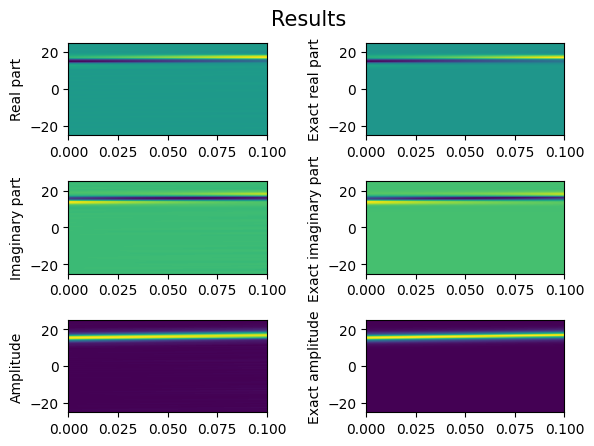

In [19]:
fig, ax = plt.subplots(3, 2)

plt.suptitle("Results", fontsize=15, x=0.5, y=0.95)

ax[0, 0].set_ylabel("Real part")
ax[0, 0].imshow(
    u.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[1, 0].set_ylabel("Imaginary part")
ax[1, 0].imshow(
    v.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[2, 0].set_ylabel("Amplitude")
ax[2, 0].imshow(
    q.T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)

ax[0, 1].set_ylabel("Exact real part")
ax[0, 1].imshow(
    u_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[1, 1].set_ylabel("Exact imaginary part")
ax[1, 1].imshow(
    v_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)
ax[2, 1].set_ylabel("Exact amplitude")
ax[2, 1].imshow(
    q_exact(X, T).T,
    interpolation="nearest",
    cmap="viridis",
    extent=[t_lower, t_upper, x_l, x_r],
    origin="lower",
    aspect="auto",
)

plt.subplots_adjust(wspace=0.5, hspace=0.5)

plt.show()